## Imports

In [1]:
import configparser

In [32]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField, DecimalType

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.registry import registry

import json

import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [33]:
# !pip install snowflake-ml-python --index-url https://repo.anaconda.com/pkgs/snowflake

In [34]:
my_dir = os.getcwd()
# connection_parameters = json.load(open(f'{my_dir}/creds.json'))
connection_parameters = json.load(open('/Users/skhara/Documents/Code/creds.json'))
session = Session.builder.configs(connection_parameters).create()

# <font color='red'>Snowpark with Big Data</font>

In [25]:
snow_df = session.table('CITIBIKEML_JACK.DEMO.TRIPS')

In [29]:
%%time
snow_df.limit(5).to_pandas()

CPU times: user 5.68 ms, sys: 11.6 ms, total: 17.3 ms
Wall time: 1.34 s


,START_STATION_NAME,START_STATION_ID,END_STATION_NAME,END_STATION_ID,START_STATION_LATITUDE,START_STATION_LONGITUDE,END_STATION_LATITUDE,END_STATION_LONGITUDE,USERTYPE,STARTTIME,STOPTIME
0,Broadway & W 41 St,465,Broadway & W 29 St,486,40.75513557,-73.98658032,40.7462009,-73.98855723,Subscriber,2019-04-22 07:33:44.010,2019-04-22 07:40:28.140
1,W 24 St & 7 Ave,446,11 Ave & W 27 St,458,40.74487634,-73.99529885,40.751396,-74.005226,Subscriber,2019-04-22 07:42:50.814,2019-04-22 07:48:58.660
2,E 10 St & Avenue A,445,E 12 St & 3 Ave,483,40.72740794,-73.98142006,40.73223272,-73.98889957,Subscriber,2019-04-22 07:48:38.126,2019-04-22 07:56:55.905
3,W 22 St & 8 Ave,453,Broadway & E 22 St,402,40.74475148,-73.99915362,40.7403432,-73.98955109,Subscriber,2019-04-22 07:49:08.542,2019-04-22 07:54:50.276
4,W 43 St & 6 Ave,524,E 51 St & Lexington Ave,522,40.75527307,-73.98316936,40.75714758,-73.97207836,Subscriber,2019-04-22 07:56:52.541,2019-04-22 08:03:30.863


In [8]:
%%time
print('Size of the Snowpark DF: ', snow_df.count())

Size of the Snowpark DF:  103835123
CPU times: user 4.79 ms, sys: 2.23 ms, total: 7.02 ms
Wall time: 618 ms


In [9]:
# Retrieve the last query ID directly using Snowpark's session object
# This uses the LAST_QUERY_ID() function which gives the ID of the last query executed in the session
last_query_id = session.sql("SELECT LAST_QUERY_ID()").collect()[0][0]
print(f"The last query ID is: {last_query_id}")

The last query ID is: 01b22c94-0002-09ff-0021-d9870044600e


In [30]:
%%time
pandas_df = snow_df.with_column("date", F.to_date("STARTTIME")).group_by("date").count().sort("date").to_pandas()

CPU times: user 11.1 ms, sys: 5.06 ms, total: 16.1 ms
Wall time: 1.5 s


In [8]:
pandas_df

,DATE,COUNT
0,2013-06-01,8721
1,2013-06-02,15971
2,2013-06-03,7598
3,2013-06-04,15782
4,2013-06-05,15690
...,...,...
2636,2020-08-27,69313
2637,2020-08-28,78167
2638,2020-08-29,71287
2639,2020-08-30,92434


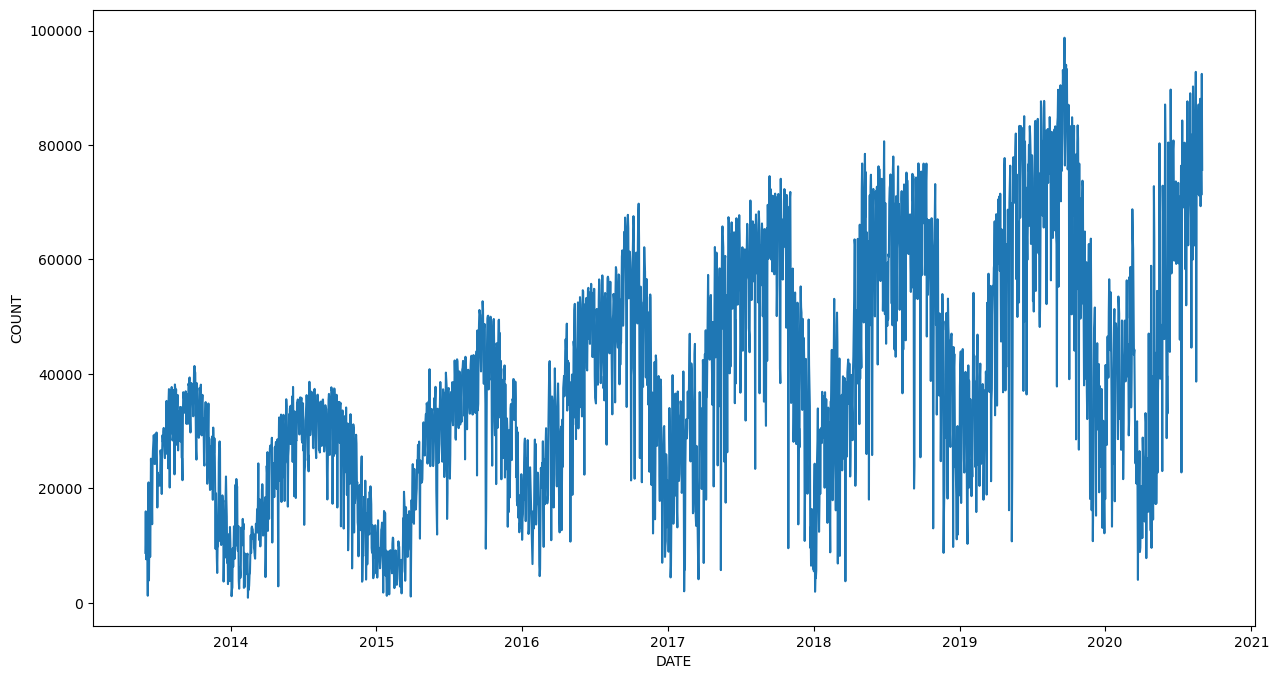

In [31]:
plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='DATE', y='COUNT', data=pandas_df)

#  
#  
# 
 
# <font color='red'>Snowpark for ML</font>

## 1.0 Prepare Data 

In [4]:
session.sql('ALTER WAREHOUSE SSK_RESEARCH SET WAREHOUSE_SIZE = "LARGE"').collect()
session.use_warehouse('SSK_RESEARCH')

In [10]:
session.use_database('DEMO_DB')
session.use_schema('PUBLIC')

In [71]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')
print('Application table size\t: ',application_record_sdf.count(), 
      '\nCredit table size\t: ', credit_record_sdf.count())

Application table size	:  438557 
Credit table size	:  1048575


In [72]:
credit_record_sdf.limit(5).to_pandas()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [73]:
# We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.
credit_record_sdf = credit_record_sdf.group_by('ID')\
                        .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3','4','5']), 1, 0)).as_("CNT_LATE"))\
                        .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")

In [74]:
# Join Credit Record data with Application Record Data
joined_sdf = application_record_sdf.join(credit_record_sdf, using_columns='ID', join_type='inner')

In [75]:
# Duplicate Removal - Use the **drop_duplicates** to remove duplicated rows
joined_sdf = joined_sdf.drop_duplicates('ID')

In [76]:
joined_sdf.count()

36457

In [77]:
# Selecting a few columns for modeling
cols_numerical = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS']
cols_categorical = ['CODE_GENDER', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
target = ['TARGET']
joined_sdf = joined_sdf[cols_numerical + cols_categorical + target]

In [78]:
joined_sdf.limit(10).to_pandas()

,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,CNT_FAM_MEMBERS,CODE_GENDER,NAME_HOUSING_TYPE,OCCUPATION_TYPE,TARGET
0,67500.0,-213,1,4.0,F,With parents,Core staff,0
1,90000.0,-1536,1,2.0,F,Rented apartment,Core staff,0
2,202500.0,-127,1,3.0,M,House / apartment,Laborers,0
3,112500.0,-1508,1,3.0,M,House / apartment,Drivers,0
4,135000.0,-4428,1,2.0,F,House / apartment,Managers,0
5,202500.0,-3166,1,2.0,F,House / apartment,Sales staff,0
6,157500.0,-3078,1,1.0,F,House / apartment,Managers,0
7,126000.0,-5553,1,2.0,M,House / apartment,None,0
8,360000.0,-2475,1,3.0,F,House / apartment,None,0
9,270000.0,-2408,1,2.0,F,House / apartment,None,0


In [79]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OHE",
                snowml.OneHotEncoder(
                    input_cols=cols_categorical,
                    output_cols=cols_categorical,
                    drop_input_cols=True
                )
            ),
            (
                "XGBModel",
                XGBClassifier(
                    random_state=123,
                    input_cols=feature_cols,
                    label_cols=target_col,
                    output_cols='PREDICTION',
                )
            )
    ]
)

transformed_df = preprocessing_pipeline.fit(joined_sdf).transform(joined_sdf)
transformed_df.limit(5).to_pandas()

,AMT_INCOME_TOTAL,DAYS_EMPLOYED,FLAG_MOBIL,CNT_FAM_MEMBERS,CODE_GENDER_F,CODE_GENDER_M,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,...,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATION_TYPE_None,TARGET
0,-1.170923,-0.442057,0.0,-0.217680,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,-0.596198,-0.431676,0.0,0.879204,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.287994,2.222894,0.0,-1.314564,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,1.260605,-0.451247,0.0,0.879204,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.818509,2.222894,0.0,-0.217680,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [80]:
transformed_df.columns

['AMT_INCOME_TOTAL',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'CNT_FAM_MEMBERS',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 '"NAME_HOUSING_TYPE_Co-op apartment"',
 '"NAME_HOUSING_TYPE_House / apartment"',
 '"NAME_HOUSING_TYPE_Municipal apartment"',
 '"NAME_HOUSING_TYPE_Office apartment"',
 '"NAME_HOUSING_TYPE_Rented apartment"',
 '"NAME_HOUSING_TYPE_With parents"',
 '"OCCUPATION_TYPE_Accountants"',
 '"OCCUPATION_TYPE_Cleaning staff"',
 '"OCCUPATION_TYPE_Cooking staff"',
 '"OCCUPATION_TYPE_Core staff"',
 '"OCCUPATION_TYPE_Drivers"',
 '"OCCUPATION_TYPE_HR staff"',
 '"OCCUPATION_TYPE_High skill tech staff"',
 '"OCCUPATION_TYPE_IT staff"',
 '"OCCUPATION_TYPE_Laborers"',
 '"OCCUPATION_TYPE_Low-skill Laborers"',
 '"OCCUPATION_TYPE_Managers"',
 '"OCCUPATION_TYPE_Medicine staff"',
 '"OCCUPATION_TYPE_Private service staff"',
 '"OCCUPATION_TYPE_Realty agents"',
 '"OCCUPATION_TYPE_Sales staff"',
 '"OCCUPATION_TYPE_Secretaries"',
 '"OCCUPATION_TYPE_Security staff"',
 '"OCCUPATION_TYPE_Waiters/barmen staff"',
 

In [81]:
# Cleaning column names to make it easier for future referencing
import re

cols = transformed_df.columns
for old_col in cols:
    new_col = re.sub(r'[^a-zA-Z0-9_]', '', old_col)
    new_col = new_col.upper()
    transformed_df = transformed_df.rename(col(old_col), new_col)

In [82]:
# Split the data and save the train and test sets as tables in Snowflake
snowdf_train, snowdf_test = transformed_df.random_split([0.8, 0.2], seed=82) 
snowdf_train.write.mode("overwrite").save_as_table("CREDIT_DEFAULT_TRAIN")
snowdf_test.write.mode("overwrite").save_as_table("CREDIT_DEFAULT_TEST")

## 2.0 ML Modeling

In [35]:
session.sql('ALTER WAREHOUSE SSK_RESEARCH SET WAREHOUSE_SIZE = "LARGE"').collect()
session.use_warehouse('SSK_RESEARCH')

In [36]:
# Prepare Data for modeling
snowdf_train = session.table('DEMO_DB.PUBLIC.CREDIT_DEFAULT_TRAIN')
feature_cols = snowdf_train.columns
target_col = 'TARGET'
feature_cols.remove(target_col)

In [21]:
# Define the XGBClassifier and fit the model
from snowflake.ml.modeling.xgboost import XGBClassifier
xgbmodel = XGBClassifier(random_state=123, input_cols=feature_cols, label_cols=target_col, output_cols='PREDICTION')
xgbmodel.fit(snowdf_train)

In [12]:
# Score the data using the fitted xgbmodel
snowdf_test = session.table('CREDIT_DEFAULT_TEST')
scored_sdf = xgbmodel.predict(snowdf_test)
print(snowdf_test.count())

7107


In [48]:
# Calculate Metrics
from snowflake.ml.modeling.metrics import f1_score, accuracy_score
F1 = f1_score(df = scored_sdf,
              y_true_col_names = 'TARGET',
              y_pred_col_names = 'PREDICTION')
ACCURACY = accuracy_score(df = scored_sdf,
                          y_true_col_names = 'TARGET',
                          y_pred_col_names = 'PREDICTION')
print(f'F1 Score: {F1} \nAccuracy Score: {ACCURACY}')

DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


F1 Score: 0.02941176470588235 
Accuracy Score: 0.981427


### Now, let's use Snowpark ML's Distributed GridSearchCV() function to find optimal model parameters

In [35]:
from snowflake.ml.modeling.xgboost import XGBClassifier

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        "n_estimators":[100, 200],
        "learning_rate":[0.3],
        "max_depth": [1,3]
    },
    n_jobs = 1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=feature_cols,
    label_cols=target_col,
    output_cols='PREDICTION'
)

# Train
grid_search.fit(snowdf_train)

In [16]:
db = 'DEMO_DB'
schema = 'CREDIT_APPROVAL'

# Create a registry and log the model
native_registry = registry.Registry(session=session, database_name=db, schema_name=schema)
native_registry.show_models()

,created_on,name,database_name,schema_name,comment,owner,default_version_name,versions
0,2024-01-23 18:49:21.897000-08:00,DEMO_CREDIT_XGB,DEMO_DB,CREDIT_APPROVAL,None,ACCOUNTADMIN,V0,"[""V0"",""V1"",""V2_2024_02_14"",""V3_2024_02_14"",""V4..."


In [37]:
# Define model name
model_name = "DEMO_CREDIT_XGB"
model_version = f"V4_{pd.datetime.now().strftime('%Y_%m_%d')}"

# Let's log the best model trained
model_ver = native_registry.log_model(
    model_name= model_name,
    version_name= model_version,
    model= grid_search
)

In [18]:
model_name = "DEMO_CREDIT_XGB"
model_version = f"V4_{pd.datetime.now().strftime('%Y_%m_%d')}"

native_registry.get_model(model_name).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-01-23 18:49:21.924000-08:00,V0,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,true,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
1,2024-01-23 18:50:41.821000-08:00,V1,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
2,2024-02-14 11:26:36.690000-08:00,V_2024_02_14,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
3,2024-02-14 11:41:56.947000-08:00,V2_2024_02_14,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
4,2024-02-14 11:49:08.786000-08:00,V3_2024_02_14,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
5,2024-02-14 14:08:08.085000-08:00,V4_2024_02_14,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
6,2024-02-14 14:17:06.122000-08:00,V5_2024_02_14,None,DEMO_DB,CREDIT_APPROVAL,DEMO_CREDIT_XGB,false,"[""PREDICT_PROBA"",""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."


In [24]:
snowdf_test = session.table('CREDIT_DEFAULT_TEST')
model_name = "DEMO_CREDIT_XGB"
model_version = 'V0'

model_ver = native_registry.get_model(model_name).version(model_version)
model_ver.show_functions()

[{'name': 'PREDICT',
  'target_method': 'predict',
  'signature': ModelSignature(
                      inputs=[
                          FeatureSpec(dtype=DataType.DOUBLE, name='AMT_INCOME_TOTAL'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='DAYS_EMPLOYED'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='FLAG_MOBIL'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='CNT_FAM_MEMBERS'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='CODE_GENDER_F'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='CODE_GENDER_M'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_COOPAPARTMENT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_HOUSEAPARTMENT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_MUNICIPALAPARTMENT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_OFFICEAPARTMENT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_RENTEDAPARTMENT'),
  		FeatureSpec(dtype=DataType.DOUBLE, name='NAME_HOUSING_TYPE_WITHPARENTS'),
  	

In [ ]:
snowdf_test = session.table('CREDIT_DEFAULT_TEST')
model_name = "DEMO_CREDIT_XGB"
model_version = 'V0'

model_ver = native_registry.get_model(model_name).version(model_version)
result_sdf2 = model_ver.run(snowdf_train, function_name="predict")

In [ ]:
result_sdf2.write.mode("overwrite").save_as_table("RESULTS")

# Want to Deploy and Schedule Your Code?

In [ ]:
from snowflake.core import Root
from snowflake.core.task import StoredProcedureCall, Task
from snowflake.core.task.dagv1 import DAGOperation, DAG, DAGTask
from datetime import date, timedelta

In [ ]:
api_root = Root(session)

In [ ]:
def func_data_preprocess_pipeline(session:Session) -> str:
    import snowflake.snowpark.functions as F
    from snowflake.snowpark.functions import udf
    from snowflake.ml.modeling.preprocessing import OneHotEncoder
    import re
    
    session.use_database('DEMO_DB')
    session.use_schema('PUBLIC')

    # Creating a Snowpark DataFrame
    application_record_sdf = session.table('APPLICATION_RECORD')
    credit_record_sdf = session.table('CREDIT_RECORD')

    # We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.
    credit_record_sdf = credit_record_sdf.group_by('ID')\
                            .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3','4','5']), 1, 0)).as_("CNT_LATE"))\
                            .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")

    
    # Join Credit Record data with Application Record Data
    joined_sdf = application_record_sdf.join(credit_record_sdf, using_columns='ID', join_type='inner')
    # Duplicate Removal - Use the **drop_duplicates** to remove duplicated rows
    joined_sdf = joined_sdf.drop_duplicates('ID')

    # Selecting a few columns for modeling
    cols_numerical = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'CNT_FAM_MEMBERS', 'TARGET']
    cols_categorical = ['CODE_GENDER', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
    joined_sdf = joined_sdf[cols_numerical+cols_categorical]

    # Perform One-Hot-Encoding for categorical columns
    my_ohe_encoder = OneHotEncoder(input_cols=cols_categorical, output_cols=cols_categorical, drop_input_cols=True)
    prepared_sdf = my_ohe_encoder.fit(joined_sdf).transform(joined_sdf)

    cols = prepared_sdf.columns
    for old_col in cols:
        new_col = re.sub(r'[^a-zA-Z0-9_]', '', old_col)
        new_col = new_col.upper()
        prepared_sdf = prepared_sdf.rename(col(old_col), new_col)

    # Save the data as table in Snowflake
    prepared_sdf.write.mode("overwrite").save_as_table("PIPE_CREDIT_DEFAULT")
    
    return f"Preprocessing pipeline ran successfully"

In [ ]:
def func_inference_pipeline(session:Session) -> str:
    from snowflake.ml.registry import registry
    registry = registry.Registry(session=session, database_name=db, schema_name=schema)
    
    # Get data
    snowdf_test = session.table('PIPE_CREDIT_DEFAULT')
    model_name = "DEMO_CREDIT_XGB"
    model_ver = registry.get_model(model_name).default
    result_sdf = model_ver.run(snowdf_test, function_name="predict")
    result_sdf.write.mode("overwrite").save_as_table("SCORED_CREDIT_DEFAULT")
    return f"Inference pipeline ran successfully"

#### Setup Tasks

In [ ]:
schema = api_root.databases['DEMO_DB'].schemas['PUBLIC']
tasks = schema.tasks

In [ ]:
# Task 1 stuff
task1_entity = Task(
    "preprocess_pipeline",
    definition=StoredProcedureCall(func_data_preprocess_pipeline, stage_location="@ML_MODELS", packages=["snowflake-snowpark-python","snowflake-ml-python", "regex"]),
    warehouse='SSK_RESEARCH',
    schedule=timedelta(days=1))

task1 = tasks.create(task1_entity, mode="orReplace")

In [ ]:
# Task 2 stuff
task2_entity = Task(
    "inference_pipeline",
    definition=StoredProcedureCall(func_inference_pipeline, stage_location="@ML_MODELS", packages=["snowflake-snowpark-python"]),
    warehouse='SSK_RESEARCH')

task2_entity.predecessors = ["DEMO_DB.PUBLIC.PREPROCESS_PIPELINE"]
task2 = tasks.create(task2_entity, mode="orReplace")

In [ ]:
task2.resume()
task1.resume()